# Spotify Data Analysis: Song Popularity Predictions.

The objective of this notebook is to predict the popularity of a song using a 600k song dataset from Kaggle:
https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks

We will use a mix of categorical and numerical features from 'tracks.csv' to perform a multi-linear regression using Scikit-Learn Pipelines. The objective is to minimize the "mean_absolute_error" metric of a numerical target feature.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.metrics import mean_absolute_error

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

The dataset has 20 features (numerical and categorical) and has nearly 600 000 songs. Let's check for Nan values. The column 'name' is the only column with NaN values and it will be dropped later on as it is of no use for our model:

In [2]:
df = pd.read_csv('Dataset/tracks.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          58

In [3]:
df.head(10)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4
5,0BRXJHRNGQ3W4v9frnSfhu,Ave Maria,0,178933,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.227,0.2610,5,-12.343,1,0.0382,0.994,0.247000,0.0977,0.0539,118.891,4
6,0Dd9ImXtAtGwsmsAD69KZT,La Butte Rouge,0,134467,0,['Francis Marty'],['2nuMRGzeJ5jJEKlfS7rZ0W'],1922,0.510,0.3550,4,-12.833,1,0.1240,0.965,0.000000,0.1550,0.7270,85.754,5
7,0IA0Hju8CAgYfV1hwhidBH,La Java,0,161427,0,['Mistinguett'],['4AxgXfD7ISvJSTObqm4aIE'],1922,0.563,0.1840,4,-13.757,1,0.0512,0.993,0.000016,0.3250,0.6540,133.088,3
8,0IgI1UCz84pYeVetnl1lGP,Old Fashioned Girl,0,310073,0,['Greg Fieler'],['5nWlsH5RDgFuRAiDeOFVmf'],1922,0.488,0.4750,0,-16.222,0,0.0399,0.620,0.006450,0.1070,0.5440,139.952,4
9,0JV4iqw2lSKJaHBQZ0e5zK,Martín Fierro - Remasterizado,0,181173,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-29,0.548,0.0391,6,-23.228,1,0.1530,0.996,0.933000,0.1480,0.6120,75.595,3


Let's shuffle our dataset and visualize the distribution of the 'popularity' target feature (100 bins for 0-100 ratings):

<AxesSubplot:ylabel='Frequency'>

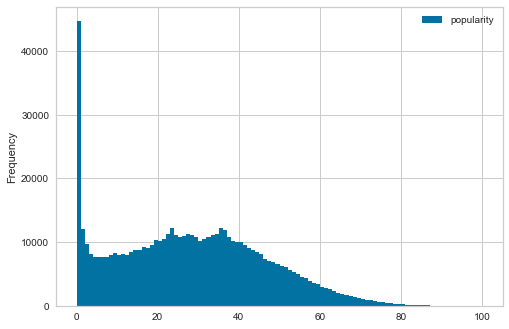

In [4]:
df = df.sample(frac=1).reset_index(drop=True)
df[['popularity']].plot.hist(bins=100)

It seems like a significant amount of songs were not rated, or very rarely/poorly rated (no information about rating methods was provided). Consequently, our distribution appears to be skewed by these outliers. in order to preserve a more Gaussian-like distribution, let's get rid of them so we can learn relevant patterns from the rest of our data:

<AxesSubplot:ylabel='Frequency'>

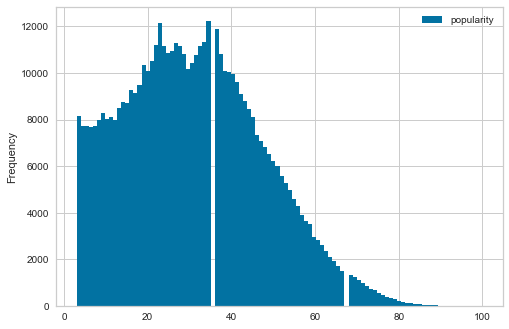

In [5]:
df.drop(df[df['popularity']<3].index, inplace=True)
df[['popularity']].plot.hist(bins=100)

Some songs might have badly encoded/skewed features: getting rid of songs that have 'tempo'==0 (which is technically impossible) and making sure these outliers are not simply spoken files by checking their 'speechiness'.
Also getting rid of songs which have a 'time_signature' of 0 or 1 (which is technically impossible).

In [6]:
df.drop(df[(df['tempo']==0) & (df['speechiness']==0)].index, inplace=True)
df.drop(df[df['time_signature']<2].index, inplace=True)

Now let's define our X input matrix and y target vector:

In [7]:
X = df[['explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']]
X.describe()

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,514919.000000,514919.000000,514919.000000,514919.000000,514919.000000,514919.000000,514919.000000,514919.000000,514919.000000,514919.000000,514919.000000,514919.000000,514919.000000
mean,0.048396,0.569720,0.564994,5.227088,-9.800890,0.654952,0.097715,0.411296,0.087655,0.212724,0.558458,119.321963,3.914864
std,0.214602,0.163073,0.242824,3.523903,4.794422,0.475385,0.165562,0.331259,0.235690,0.185266,0.255341,29.413033,0.334220
min,0.000000,0.053200,0.000000,0.000000,-54.837000,0.000000,0.000000,0.000000,0.000000,0.005720,0.000000,30.506000,3.000000
25%,0.000000,0.462000,0.384000,2.000000,-12.362500,0.000000,0.033400,0.084000,0.000000,0.096900,0.353000,96.387000,4.000000
50%,0.000000,0.582000,0.576000,5.000000,-8.910000,1.000000,0.043300,0.364000,0.000014,0.137000,0.569000,118.128000,4.000000
75%,0.000000,0.689000,0.763000,8.000000,-6.313000,1.000000,0.073400,0.718000,0.003450,0.276000,0.774000,137.273000,4.000000
max,1.000000,0.991000,1.000000,11.000000,5.376000,1.000000,0.971000,0.996000,1.000000,1.000000,1.000000,246.381000,5.000000


Let's use Seaborn capabilities to derive insights from feature correlation. The following plots show no significant correlation between features. Straight parallel lines belong to categorical features (integer values) that will be processed as such later on.

In [ ]:
sns.pairplot(X)

In [ ]:
y = df.popularity.values

Now let's cast the categorical columns type as 'category' and then use the sklearn selector() method to create a list of numerical columns and a list of categorical columns:

In [ ]:
X.loc[:, ['explicit', 'key', 'mode', 'time_signature']] = X.loc[:, ['explicit', 'key', 'mode', 'time_signature']].astype('category')

In [ ]:
numerical_columns_selector = selector(dtype_exclude='category')
categorical_columns_selector = selector(dtype_include='category')

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

In [ ]:
numerical_columns

In [ ]:
categorical_columns

In [ ]:
X.dtypes

Now let's define the transformers (preprocessors) for our sklearn pipeline: OneHotEncoder() for categorical columns and StandardScaler() for numerical columns.

In [ ]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

The ColumnTransformer splits the columns of the original dataset based on column names, transforms each subset  by calling the predefined fit_transform and finally concatenates the transformed datasets into a single dataset for training. The same steps will be applied when calling the predict() method.

In [ ]:
preprocessor = ColumnTransformer([
    ('One-Hot-Encoder', categorical_preprocessor, categorical_columns),
    ('Standard-Scaler', numerical_preprocessor, numerical_columns)])

Let's define our model (default number of iteration for training = 1000 epochs) and let's visualize our pipeline architecture:

In [ ]:
model = make_pipeline(preprocessor, LinearRegression())
set_config(display='diagram')
model

Let's split the data into train and test sets with a 80/20 ratio:

In [ ]:
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.2)

Training the model:

In [ ]:
_ = model.fit(data_train, target_train)

Predictions and performance metrics for training and test sets: the MAE metric is quite similar for both sets.

In [ ]:
pred_test = model.predict(data_test)
pred_train = model.predict(data_train)

In [ ]:
mean_absolute_error(target_train, pred_train)

In [ ]:
mean_absolute_error(target_test, pred_test)

In [ ]:
visualizer = ResidualsPlot(model, hist=True, qqplot=False)
visualizer.fit(data_train, target_train)
visualizer.score(data_test, target_test)
visualizer.show()

In [ ]:
Now let's visualize the predictions error and the R-squared metric. The latter is a ratio between the variance explained by the model and the total variance. 

In [ ]:
visualizer = PredictionError(model)
visualizer.fit(data_train, target_train)
visualizer.score(data_test, target_test)
visualizer.show()

In [ ]:
err = abs(target_test - pred_test)
error = pd.DataFrame(err, columns = ['error'])
error.plot.hist(bins=100)

In [ ]:
error.describe()

In [ ]:
predictions = pd.DataFrame(pred_test, columns=['predictions'])
predictions.plot.hist(bins=100)

In [ ]:
predictions.describe()